# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [8]:
class LinearRegression: 
    def __init__(self, alpha=1, learning_rate=1e-3, tolerance=1e-4, max_iter=1000):
        
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iter = max_iter
        np.random.seed(42)
        
    def fit(self, X, y):
        
        self.bias = np.random.normal() # сдвиг, скаляр
        self.theta = np.random.normal(size=X.shape[1])
        self.loss_history = []
        
        for _ in range(self.max_iter):
            prev_bias, prev_theta = self.bias, self.theta.copy()
            
            bias_grad, theta_grad = self.calculate_grad(X, y)
            self.bias -= self.learning_rate * bias_grad
            self.theta -= self.learning_rate * theta_grad
            
            prev_vector = np.append(prev_theta, prev_bias)
            current_vector = np.append(self.theta, self.bias)
            
            self.loss_history.append(self.calculate_loss(X, y))
            if np.linalg.norm(current_vector - prev_vector) < self.tolerance:
                break
        
    def predict(self, X):        
        return X @ self.theta + self.bias
    
    def calculate_grad(self, X, y):
        preds = self.predict(X)
        bias_grad =  np.mean((preds - y) * 2, axis = 0)
        W_grad = 2 * X.T @ (preds - y) / y.shape[0] + self.alpha * np.sign(self.theta)

        return bias_grad, W_grad
    
    def calculate_loss(self, X, y): 
        return np.mean((self.predict(X) - y) ** 2) + self.alpha * np.linalg.norm(self.theta, ord=1)

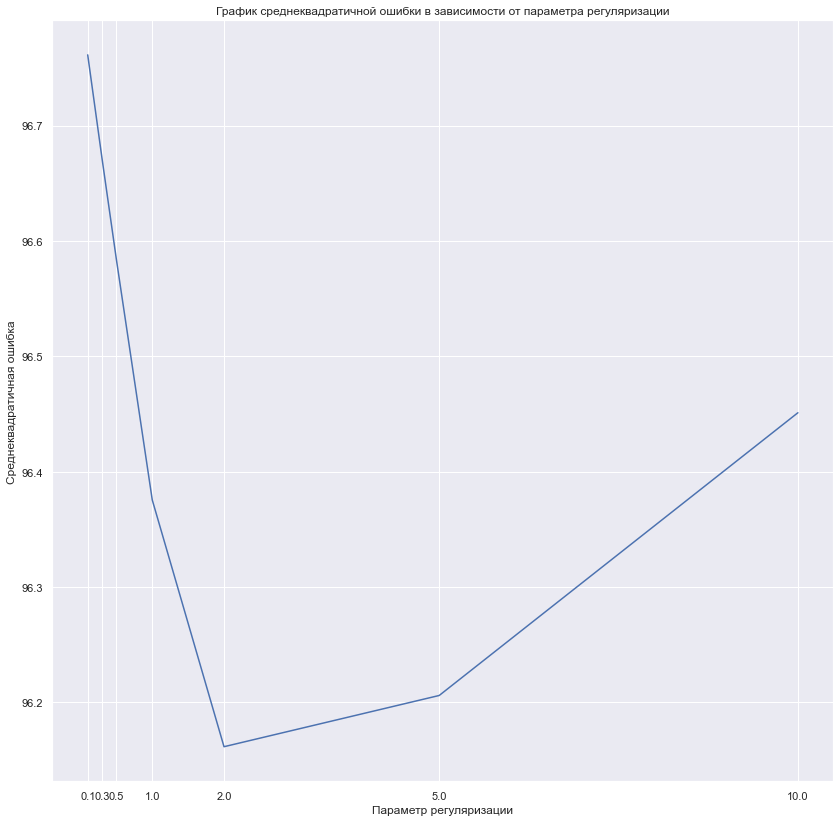

In [9]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

mse_results = []
alpha_grid = [0.1, 0.3, 0.5, 1, 2, 5, 10]
for alpha in alpha_grid:
    linreg = LinearRegression(alpha=alpha)
    linreg.fit(X, Y)
    mse_results.append(mean_squared_error(Y, linreg.predict(X)))
    
plt.figure(figsize=(14, 14))
plt.title('График среднеквадратичной ошибки в зависимости от параметра регуляризации')
plt.xlabel('Параметр регуляризации')
plt.ylabel('Среднеквадратичная ошибка')
plt.plot(alpha_grid, mse_results)
plt.xticks(alpha_grid)
plt.show()

In [10]:
indices = np.arange(Y.shape[0])

folds = 5
alpha_grid = [0.1, 0.3, 0.5, 1, 2, 5, 10]
train_mse_dict = {alpha: [] for alpha in alpha_grid}
test_mse_dict  = {alpha: [] for alpha in alpha_grid}
for alpha in alpha_grid:
    train_mse_list = []
    test_mse_list = []
    for test_start in range(0, len(indices), int(len(indices) / folds)):
        test_stop = test_start + int(len(indices) / folds)

        X_test, y_test = X[indices[test_start:test_stop]], Y[indices[test_start:test_stop]]
        X_train, y_train = X[np.concatenate((indices[:test_start], indices[test_stop:]))],\
                           Y[np.concatenate((indices[:test_start], indices[test_stop:]))]
        
        linreg = LinearRegression(alpha=alpha)
        linreg.fit(X_train, y_train)
        
        y_train_pred = linreg.predict(X_train)
        y_test_pred = linreg.predict(X_test)
          
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        train_mse_dict[alpha].append(train_mse)
        test_mse_dict[alpha].append(test_mse)
    

In [11]:
train_mse_mean = {alpha: np.mean(train_mse_dict[alpha]) for alpha in alpha_grid}
test_mse_mean = {alpha: np.mean(test_mse_dict[alpha]) for alpha in alpha_grid}

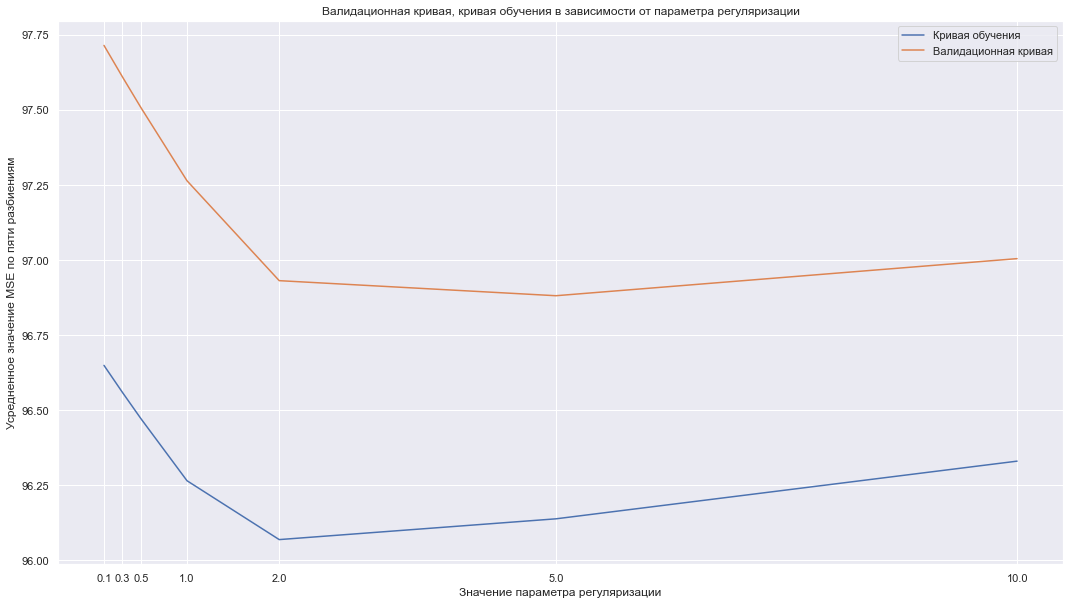

In [14]:
plt.figure(figsize=(18, 10))
plt.title('Валидационная кривая, кривая обучения в зависимости от параметра регуляризации')
plt.xlabel('Значение параметра регуляризации')
plt.ylabel('Усредненное значение MSE по пяти разбиениям')
plt.plot(alpha_grid, train_mse_mean.values(), label='Кривая обучения')
plt.plot(alpha_grid, test_mse_mean.values(), label='Валидационная кривая')
plt.xticks(alpha_grid)
plt.legend()
plt.show()